<h3>Translate French sentences to English using Seq2Seq model</h3>
<p>The notebook includes the steps to build a encoder-decoder model with attention from scratch in PyTorch. This is also called as a Sequence-to-Sequence model, which is used here to train a language translator from French to English.</p>

In [1]:
%%bash

# Download and unzip dataset
curl -o data.zip https://download.pytorch.org/tutorial/data.zip

data_dir="pytorch_seq2seq"
rm -r $data_dir
unzip data.zip -d $data_dir
rm data.zip

Archive:  data.zip
   creating: pytorch_seq2seq/data/
  inflating: pytorch_seq2seq/data/eng-fra.txt  
   creating: pytorch_seq2seq/data/names/
  inflating: pytorch_seq2seq/data/names/Arabic.txt  
  inflating: pytorch_seq2seq/data/names/Chinese.txt  
  inflating: pytorch_seq2seq/data/names/Czech.txt  
  inflating: pytorch_seq2seq/data/names/Dutch.txt  
  inflating: pytorch_seq2seq/data/names/English.txt  
  inflating: pytorch_seq2seq/data/names/French.txt  
  inflating: pytorch_seq2seq/data/names/German.txt  
  inflating: pytorch_seq2seq/data/names/Greek.txt  
  inflating: pytorch_seq2seq/data/names/Irish.txt  
  inflating: pytorch_seq2seq/data/names/Italian.txt  
  inflating: pytorch_seq2seq/data/names/Japanese.txt  
  inflating: pytorch_seq2seq/data/names/Korean.txt  
  inflating: pytorch_seq2seq/data/names/Polish.txt  
  inflating: pytorch_seq2seq/data/names/Portuguese.txt  
  inflating: pytorch_seq2seq/data/names/Russian.txt  
  inflating: pytorch_seq2seq/data/names/Scottish.txt  
 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2814k  100 2814k    0     0  1177k      0  0:00:02  0:00:02 --:--:-- 1176k


In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [3]:
SOS_token = 0
EOS_token = 1

# Class to define index and count of each word
class Lang:
    def __init__(self, name):
        self.name = name
        
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}

        # Count SOS and EOS
        self.n_words = 2  

    def addSentence(self, sentence):
        for word in sentence.split(" "):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [5]:
LANG1 = "eng"
LANG2 = "fra"

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    data_path = "pytorch_seq2seq/data/{0}-{1}.txt".format(LANG1, LANG2)
    lines = open(data_path, encoding="utf-8").read().strip().split("\n")

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Define objects for both languages
    if not reverse:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    else:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)

    return input_lang, output_lang, pairs

In [6]:
# Filter sentences based on length
MAX_LENGTH = 10

# Filter sentences based on input prefix
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    if len(p[0].split(" ")) >= MAX_LENGTH or len(p[1].split(" ")) >= MAX_LENGTH:
        return False
    elif p[0].startswith(eng_prefixes) or p[1].startswith(eng_prefixes):
        return True
    else:
        return False
    
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [7]:
# Read dataset and construct language pairs
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
        
    print("Summary: {0} {1} | {2} {3}" \
          .format(input_lang.name, input_lang.n_words, output_lang.name, output_lang.n_words))    

    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData(LANG1, LANG2, True)
pair = random.choice(pairs)
print("\nExample: ", pair)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Summary: fra 4345 | eng 2803

Example:  ['elle est en train de cuisiner pour lui .', 'she is cooking for him .']


In [8]:
# Convert sentence to list of indexes
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(" ")]

# Convert sentence to a tensor
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

# Convert a data-pair to tensor-pair
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

tensor_pair = tensorsFromPair(pair)
print("Example: {0}\n{1}\n{2}".format(pair, tensor_pair[0], tensor_pair[1]))

Example: ['elle est en train de cuisiner pour lui .', 'she is cooking for him .']
tensor([[ 119],
        [  25],
        [  14],
        [ 100],
        [ 101],
        [2745],
        [1150],
        [ 247],
        [   5],
        [   1]])
tensor([[ 75],
        [ 40],
        [750],
        [739],
        [474],
        [  4],
        [  1]])


In [9]:
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    # Plot loss during the training
    plt.figure()
    plt.plot(points)
    plt.show()
    
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [10]:
# Define a class for encoder
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        # Convert a word to embedding
        embedded = self.embedding(input).view(1, 1, -1)
        
        # Compute output and next hidden state
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [11]:
# Define class for decoder
class DecoderRNN(nn.Module):
    def __init__(self, attention, hidden_size, output_size, max_length, dropout_prob):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
        self.attention = attention
        self.max_length = max_length
        if self.attention:
            self.initAttention(max_length, dropout_prob)
            
    def initAttention(self, max_length, dropout_prob):
        # Initialize attention related attributes
        self.attn = nn.Linear(self.hidden_size * 2, max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        
        if self.attention:
            embedded = self.dropout(embedded)

            # Compute attention weights from input and hidden state
            attn_input = torch.cat((embedded[0], hidden[0]), 1)
            attn_weights = F.softmax(self.attn(attn_input), dim=1)

            # Compute context vector and attention vector
            context_vector = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
            attention = torch.cat((embedded[0], context_vector[0]), 1)
            embedded = F.relu(self.attn_combine(attention).unsqueeze(0))
            
        else:
            attn_weights = None
            embedded = F.relu(embedded)

        output, hidden = self.gru(embedded, hidden)
        output = self.softmax(self.out(output[0]))

        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [12]:
# Define a class for combined network of encoder and decoder
class Seq2SeqNetwork(object):
    def __init__(self, attention, hidden_size, learning_rate, max_length, dropout_prob, teacher_forcing_ratio):
        self.teacher_forcing_ratio = teacher_forcing_ratio
        
        # Initialize encoder and decoder in the network
        self.encoder = EncoderRNN(input_lang.n_words, hidden_size)
        self.decoder = DecoderRNN(attention, hidden_size, output_lang.n_words, max_length, dropout_prob)

        # Define optimizers and loss function
        self.encoder_optimizer = optim.SGD(self.encoder.parameters(), lr=learning_rate)
        self.decoder_optimizer = optim.SGD(self.decoder.parameters(), lr=learning_rate)        
        self.criterion = nn.NLLLoss()

    def trainUtil(self, input_tensor, target_tensor):
        # Train network with a single data pair

        loss = 0
        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)
    
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()
        
        # Initalize array for encoder outputs and encoder hidden state
        encoder_outputs = torch.zeros(self.decoder.max_length, self.encoder.hidden_size)
        encoder_hidden = self.encoder.initHidden()
        
        for ei in range(input_length):
            encoder_output, encoder_hidden = self.encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

        # Initialize decoder input and hidden state
        decoder_hidden = encoder_hidden
        decoder_input = torch.tensor([[SOS_token]])
        
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

        for di in range(target_length):
            result = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_output, decoder_hidden, decoder_attention = result

            loss += self.criterion(decoder_output, target_tensor[di])

            if use_teacher_forcing:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[di]

            elif decoder_input.item() != EOS_token:
                # Without teacher forcing: use its own predictions as the next input
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()

            else:
                break

        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        return loss.item() / target_length
    
    def train(self, n_iters, print_every=1000, plot_every=100):
        start = time.time()
        print_loss_total = 0  
        plot_loss_total = 0 
        plot_losses = []
        
        for iter in range(1, n_iters + 1):
            input_tensor, target_tensor = tensorsFromPair(random.choice(pairs))
            loss = self.trainUtil(input_tensor, target_tensor)

            print_loss_total += loss
            plot_loss_total += loss

            if iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) Loss: %.4f' % (timeSince(start, iter / n_iters),
                                             iter, iter / n_iters * 100, print_loss_avg))

            if iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
        
        showPlot(plot_losses)
        
    def evaluateUtil(self, max_length=MAX_LENGTH):
        sentence, target = random.choice(pairs)
        
        # Computations without gradient
        with torch.no_grad():
            input_tensor = tensorFromSentence(input_lang, sentence)
            input_length = input_tensor.size()[0]

            encoder_outputs = torch.zeros(self.decoder.max_length, self.encoder.hidden_size)
            encoder_hidden = self.encoder.initHidden()
            
            for ei in range(input_length):
                encoder_output, encoder_hidden = self.encoder(input_tensor[ei], encoder_hidden)
                encoder_outputs[ei] = encoder_output[0, 0]

            decoder_input = torch.tensor([[SOS_token]])
            decoder_hidden = encoder_hidden

            # Initalize array for attention
            decoder_attentions = torch.zeros(self.decoder.max_length, self.decoder.max_length)
            decoded_words = []
            
            for di in range(max_length):
                result = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
                decoder_output, decoder_hidden, decoder_attention = result
                decoder_attentions[di] = decoder_attention.data
                
                # Fetch the result word with largest output
                topv, topi = decoder_output.data.topk(1)
                if topi.item() == EOS_token:
                    decoded_words.append('<EOS>')
                    break
                else:
                    decoded_words.append(output_lang.index2word[topi.item()])

                # Current output from decoder is the next input
                decoder_input = topi.squeeze().detach()

        decoder_attentions = decoder_attentions[:di + 1]
        output_sentence = ' '.join(decoded_words)
        print("> {0}\n= {1}\n< {2}\n".format(sentence, target, output_sentence))
        return sentence, target, output_sentence, decoder_attentions
        
    def evaluate(self, n_iters):
        for i in range(n_iters):
            self.evaluateUtil()
            
    def evaluate_attention(self):
        # Show attention weights in decoder
        sentence, target, output_sentence, attentions = self.evaluateUtil()
        plt.matshow(attentions.numpy())

0m 35s (- 58m 35s) (1000 1%) Loss: 3.6040
1m 13s (- 59m 37s) (2000 2%) Loss: 2.9665
1m 51s (- 59m 58s) (3000 3%) Loss: 2.7957
2m 30s (- 60m 7s) (4000 4%) Loss: 2.6471
3m 9s (- 59m 55s) (5000 5%) Loss: 2.5244
3m 48s (- 59m 36s) (6000 6%) Loss: 2.4589
4m 27s (- 59m 17s) (7000 7%) Loss: 2.3891
5m 7s (- 58m 56s) (8000 8%) Loss: 2.3623
5m 45s (- 58m 17s) (9000 9%) Loss: 2.1791
6m 24s (- 57m 39s) (10000 10%) Loss: 2.1668
7m 3s (- 57m 4s) (11000 11%) Loss: 2.0499
7m 42s (- 56m 30s) (12000 12%) Loss: 2.0386
8m 21s (- 55m 53s) (13000 13%) Loss: 1.9516
9m 0s (- 55m 19s) (14000 14%) Loss: 2.0125
9m 39s (- 54m 45s) (15000 15%) Loss: 1.8926
10m 18s (- 54m 9s) (16000 16%) Loss: 1.8213
10m 57s (- 53m 32s) (17000 17%) Loss: 1.7492
11m 36s (- 52m 53s) (18000 18%) Loss: 1.7327
12m 21s (- 52m 43s) (19000 19%) Loss: 1.6691
13m 2s (- 52m 8s) (20000 20%) Loss: 1.6887
13m 42s (- 51m 35s) (21000 21%) Loss: 1.5746
14m 22s (- 50m 59s) (22000 22%) Loss: 1.5476
15m 3s (- 50m 23s) (23000 23%) Loss: 1.5627
15m 43s 

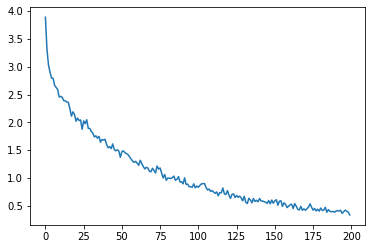

In [13]:
hidden_size = 256
learning_rate = 0.01
teacher_forcing_ratio = 0.5
dropout_prob = 0.1

model = Seq2SeqNetwork(True, hidden_size, learning_rate, MAX_LENGTH, dropout_prob, teacher_forcing_ratio)
model.train(100000, print_every=1000, plot_every=500)

In [14]:
model.evaluate(10)

> j y travaille encore .
= i m still working on it .
< i m still thinking about it . <EOS>

> c est un homme cruel .
= he is a cruel person .
< he is a cruel person . <EOS>

> je suis en train d etudier le francais .
= i m studying french .
< i m learning french . <EOS>

> tu es bonne .
= you are good .
< you are good . <EOS>

> il est incroyablement talentueux .
= he s incredibly talented .
< he s incredibly talented . <EOS>

> c est une eleve de deuxieme annee .
= she is a second year student .
< he is a sophomore . <EOS>

> tu n es pas ma mere .
= you aren t my mother .
< you re not my mother . <EOS>

> c est une blonde .
= she s a dumb blonde .
< she is a blonde blonde . <EOS>

> vous etes fort emotifs .
= you re very emotional .
< you re very emotional . <EOS>

> vous etes charmante .
= you re charming .
< you re charming . <EOS>



> c est un pauvre type .
= he s a jerk .
< he s a jerk . . <EOS>



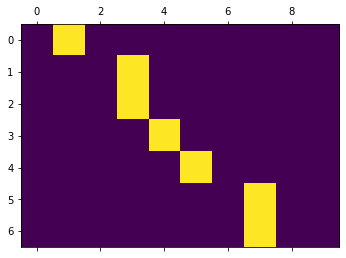

In [15]:
model.evaluate_attention()